# Sheet 1

In [74]:
!pip install pyconll

In [75]:
from transformers import BertModel, BertConfig,BertTokenizer
import nltk
import torch

import numpy as np
import pyconll
import urllib.request
import transformers
import torch.nn
from tqdm.notebook import tqdm
import torch.optim as optim
from torchtext import data
import random
from torchtext.legacy import data
import torch.nn as nn

In [76]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Load Datset

In [77]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos and token.form:
                t+=1
                tagged_sentence.append((token.form.lower(), token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

In [78]:
#train_sentences = read_conllu(UD_ENGLISH_TRAIN)
#val_sentences = read_conllu(UD_ENGLISH_DEV)
UD_Breton='../input/posbert/UD_Breton-KEB/UD_Breton-KEB/br_keb-ud-test.conllu'
UD_Yoruba='../input/posbert/UD_Yoruba-YTB/UD_Yoruba-YTB/yo_ytb-ud-test.conllu'
UD_Welsh_dev='../input/ud-welshccg/UD_Welsh-CCG/cy_ccg-ud-dev.conllu'
UD_Welsh_train='../input/ud-welshccg/UD_Welsh-CCG/cy_ccg-ud-train.conllu'
UD_Welsh_test='../input/ud-welshccg/UD_Welsh-CCG/cy_ccg-ud-test.conllu'
UD_Wolof_dev='../input/wolof-ud/UD_Wolof-WTB/wo_wtb-ud-dev.conllu'
UD_Wolof_train='../input/wolof-ud/UD_Wolof-WTB/wo_wtb-ud-train.conllu'
UD_Wolof_test='../input/wolof-ud/UD_Wolof-WTB/wo_wtb-ud-test.conllu'
Breton_sent = read_conllu(UD_Breton)
Yoruba_sent = read_conllu(UD_Yoruba)
#Welsh_dev=read_conllu(UD_Welsh_dev)
#Welsh_train=read_conllu(UD_Welsh_train)
#Welsh_test=read_conllu(UD_Welsh_test)
Wolof_dev=read_conllu(UD_Wolof_dev)
Wolof_train=read_conllu(UD_Wolof_train)
Wolof_test=read_conllu(UD_Wolof_test)

In [79]:
UD_tags_path ='../input/conllutools/cpos.ud'
UD_tags_file = open(UD_tags_path, 'r')
UD_tags = UD_tags_file.readlines()
postags = []
for line in UD_tags[:-1]:
    if ('#' not in line) and ('' != line):
        postags.append(line.replace("\n", ""))
    UD_tags_file.close()
postags

['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB']

In [80]:

Wolof_sent=Wolof_train+Wolof_test+Wolof_dev

In [81]:
postags = ["<pad>"] + postags


In [82]:
tag2idx = {tag:idx for idx, tag in enumerate(postags)}
idx2tag = {idx:tag for idx, tag in enumerate(postags)}

In [83]:
Wolof_sent=Wolof_sent[0:500]

In [84]:
len(Wolof_sent)

500

In [85]:
from sklearn.model_selection import train_test_split
br_train_data, br_test_data = train_test_split(Breton_sent, test_size=.25)
#wa_train_data, wa_test_data=train_test_split(Welsh_sent, test_size=.3)
wo_train_data, wo_test_data=train_test_split(Wolof_sent, test_size=.25)
yo_train_data, yo_test_data=train_test_split(Yoruba_sent, test_size=.25)
len(wo_train_data), len(wo_test_data)

(375, 125)

In [86]:
yo_train_data, yo_test_data = train_test_split(Yoruba_sent, test_size=.3)
len(yo_train_data), len(yo_test_data)

(222, 96)

In [87]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [88]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [89]:
class PosDataset(data.Dataset):
    def __init__(self, tagged_sents):
        sents, tags_li = [], [] # list of lists
        for sent in tagged_sents:
            words = [word_pos[0] for word_pos in sent]
            tags = [word_pos[1] for word_pos in sent]
            sents.append(["[CLS]"] + words + ["[SEP]"])
            tags_li.append(["<pad>"] + tags + ["<pad>"])
        self.sents, self.tags_li = sents, tags_li

    def __len__(self):
        return len(self.sents)

    def __getitem__(self, idx):
        words, tags = self.sents[idx], self.tags_li[idx] # words, tags: string list

       
        x, y = [], [] # list of ids
        is_heads = [] # list. 1: the token is the first piece of a word
        for w, t in zip(words, tags):
            tokens = tokenizer.tokenize(w) if w not in ("[CLS]", "[SEP]") else [w]
            xx = tokenizer.convert_tokens_to_ids(tokens)

            is_head = [1] + [0]*(len(tokens) - 1)

            t = [t] + ["<pad>"] * (len(tokens) - 1)  # <PAD>: no decision
            yy = [tag2idx[each] for each in t]  # (T,)

            x.extend(xx)
            is_heads.extend(is_head)
            y.extend(yy)

        assert len(x)==len(y)==len(is_heads), "len(x)={}, len(y)={}, len(is_heads)={}".format(len(x), len(y), len(is_heads))

        # seqlen
        seqlen = len(y)

        # to string
        words = " ".join(words)
        tags = " ".join(tags)
        return words, x, is_heads, tags, y, seqlen


In [90]:
def pad(batch):
    '''Pads to the longest sample'''
    f = lambda x: [sample[x] for sample in batch]
    words = f(0)
    is_heads = f(2)
    tags = f(3)
    seqlens = f(-1)
    maxlen = np.array(seqlens).max()

    f = lambda x, seqlen: [sample[x] + [0] * (seqlen - len(sample[x])) for sample in batch] # 0: <pad>
    x = f(1, maxlen)
    y = f(-2, maxlen)


    f = torch.LongTensor

    return words, f(x), is_heads, tags, f(y), seqlens

In [123]:
class Net(nn.Module):
    def __init__(self, modeltype='bert-base-multilingual-cased',vocab_size=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(modeltype,return_dict=False)
        self.fc = nn.Linear(768, vocab_size)
        self.device = device

    def forward(self, x, y):
        '''
        x: (N, T). int64
        y: (N, T). int64
        '''
        x = x.to(device)
        y = y.to(device)
        
        if self.training:
            self.bert.train()
            encoded_layers, _ = self.bert(x)
            enc = encoded_layers[-1]
        else:
            self.bert.eval()
            with torch.no_grad():
                encoded_layers, _ = self.bert(x)
                enc = encoded_layers[-1]
        
        logits = self.fc(enc)
        y_hat = logits.argmax(-1)
        return logits, y, y_hat

In [109]:
def train(model, iterator):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    loss_list={}
    for i, batch in enumerate(iterator):
        words, x, is_heads, tags, y, seqlens = batch
        _y = y # for monitoring
        optimizer.zero_grad()
        logits, y, _ = model(x, y) # logits: (N, T, VOCAB), y: (N, T)
        logits = logits.view((-1), logits.shape[-1]) # (N*T, VOCAB)
        y = y.view(-1)  # (N*T,)
       
       # print(torch.Size(logits))
       # print(torch.Size(y))
        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()
        
        if i%10==0: # monitoring
            print("step: {}, loss: {}".format(i, loss.item()))
            loss_list[i]=loss.item()
    return loss_list 

In [111]:
def eval(model, iterator):
    model.eval()

    Words, Is_heads, Tags, Y, Y_hat = [], [], [], [], []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            words, x, is_heads, tags, y, seqlens = batch

            _, _, y_hat = model(x, y)  # y_hat: (N, T)
            
            Words.extend(words)
            Is_heads.extend(is_heads)
            Tags.extend(tags)
            Y.extend(y.numpy().tolist())
            Y_hat.append(y_hat.cpu().numpy().tolist())
    ## gets results and save
    with open("result", 'w') as fout:
        for words, is_heads, tags, y_hat in zip(Words, Is_heads, Tags, Y_hat):
           # y_hat=y_hat[1:-1]
            y_hat = [hat for head, hat in zip(is_heads, y_hat) if head == 1]
            preds = [idx2tag[hat] for hat in y_hat]
            #assert len(preds)==len(words.split())==len(tags.split())
            for w, t, p in zip(words.split()[1:-1], tags.split()[1:-1], preds[1:-1]):
                fout.write("{} {} {}\n".format(w, t, p))
            fout.write("\n")
            
    ## calc metric
    y_true =  np.array([tag2idx[line.split()[1]] for line in open('result', 'r').read().splitlines() if len(line) > 0])
    y_pred =  np.array([tag2idx[line.split()[2]] for line in open('result', 'r').read().splitlines() if len(line) > 0])

    acc = (y_true==y_pred).astype(np.int32).sum() / len(y_true)
    print(acc)
    return acc 

In [172]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_wo = Net(vocab_size=len(tag2idx))
model_wo.to(device)
model_wo = nn.DataParallel(model_wo)


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [174]:
from torch.utils import data
wo_train_dataset = PosDataset(wo_train_data)
wo_eval_dataset = PosDataset(wo_test_data)
yo_train_dataset = PosDataset(yo_train_data)
yo_eval_dataset = PosDataset(yo_test_data)



yo_train_iter = data.DataLoader(dataset=yo_train_dataset,
                             batch_size=1,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)
yo_test_iter = data.DataLoader(dataset=yo_eval_dataset,
                             batch_size=1,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)
wo_train_iter = data.DataLoader(dataset=wo_train_dataset,
                             batch_size=1,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)
wo_test_iter = data.DataLoader(dataset=wo_eval_dataset,
                             batch_size=1,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)


#optimizer = optim.Adam(model.parameters(), lr = 0.0001)



In [175]:
Epoch=10
wo_acc=[]
wo_train=[]
i=0
while i<10: 
    wo_train.append(train(model_wo, wo_train_iter))
    wo_acc.append(eval(model_wo, wo_test_iter))
    i+=1
print(wo_acc)

step: 0, loss: 2.888134717941284
step: 10, loss: 1.6356077194213867
step: 20, loss: 1.0385125875473022
step: 30, loss: 0.9337869882583618
step: 40, loss: 0.5508790016174316
step: 50, loss: 0.7170218825340271
step: 60, loss: 0.8036861419677734
step: 70, loss: 0.7716289162635803
step: 80, loss: 0.5254815816879272
step: 90, loss: 0.7356905341148376
step: 100, loss: 0.7536472678184509
step: 110, loss: 0.5410031080245972
step: 120, loss: 0.3987736701965332
step: 130, loss: 0.36924830079078674
step: 140, loss: 0.29116639494895935
step: 150, loss: 0.533483624458313
step: 160, loss: 0.7549551129341125
step: 170, loss: 0.7114834785461426
step: 180, loss: 0.4441230297088623
step: 190, loss: 0.85006183385849
step: 200, loss: 0.5255175828933716
step: 210, loss: 0.6010774374008179
step: 220, loss: 0.33465614914894104
step: 230, loss: 0.2987624704837799
step: 240, loss: 0.7021782398223877
step: 250, loss: 0.2909950911998749
step: 260, loss: 0.2948327362537384
step: 270, loss: 0.40566813945770264
ste

In [176]:
model_yowo = Net(modeltype='Davlan/bert-base-multilingual-cased-finetuned-yoruba',vocab_size=len(tag2idx))
model_yowo.to(device)
model_yowo = nn.DataParallel(model_yowo)

Some weights of the model checkpoint at Davlan/bert-base-multilingual-cased-finetuned-yoruba were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at Davlan/bert-base-multilingual-cased-finetuned-yoruba and are newly initi

In [177]:
Epoch=10
yowo_acc=[]
yowo_train=[]
i=0
while i<10: 
    yowo_train.append(train(model_yowo, wo_train_iter))
    yowo_acc.append(eval(model_yowo, wo_test_iter))
    i+=1

print(yowo_acc)

step: 0, loss: 2.9741899967193604
step: 10, loss: 1.3345009088516235
step: 20, loss: 1.1162786483764648
step: 30, loss: 0.5463511943817139
step: 40, loss: 0.9640694260597229
step: 50, loss: 0.4672936201095581
step: 60, loss: 0.8332943916320801
step: 70, loss: 0.4982053339481354
step: 80, loss: 0.9978530406951904
step: 90, loss: 0.6925190091133118
step: 100, loss: 0.7495042681694031
step: 110, loss: 0.7440182566642761
step: 120, loss: 0.7413892149925232
step: 130, loss: 0.4013998210430145
step: 140, loss: 0.6531165242195129
step: 150, loss: 0.5924021601676941
step: 160, loss: 0.6391058564186096
step: 170, loss: 0.3855753242969513
step: 180, loss: 0.6748175024986267
step: 190, loss: 0.480172336101532
step: 200, loss: 0.05215876176953316
step: 210, loss: 0.48349303007125854
step: 220, loss: 0.4072108864784241
step: 230, loss: 0.3941448926925659
step: 240, loss: 0.3866940140724182
step: 250, loss: 0.7865357398986816
step: 260, loss: 0.4568943381309509
step: 270, loss: 0.31942814588546753
s

In [178]:
model_swwo = Net(modeltype='Davlan/bert-base-multilingual-cased-finetuned-swahili',vocab_size=len(tag2idx))
model_swwo.to(device)
model_swwo = nn.DataParallel(model_swwo)

Some weights of the model checkpoint at Davlan/bert-base-multilingual-cased-finetuned-swahili were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at Davlan/bert-base-multilingual-cased-finetuned-swahili and are newly ini

In [179]:
Epoch=10
swwo_acc=[]
swwo_train=[]
i=0
while i<10: 
    swwo_train.append(train(model_swwo, wo_train_iter))
    swwo_acc.append(eval(model_swwo, wo_test_iter))
    i+=1
print(swwo_acc)

step: 0, loss: 2.7803096771240234
step: 10, loss: 2.1786231994628906
step: 20, loss: 1.1785383224487305
step: 30, loss: 1.0362190008163452
step: 40, loss: 0.7631415128707886
step: 50, loss: 0.45705127716064453
step: 60, loss: 0.5076994299888611
step: 70, loss: 1.0313832759857178
step: 80, loss: 0.8747393488883972
step: 90, loss: 0.6641660332679749
step: 100, loss: 0.5760027766227722
step: 110, loss: 0.656756579875946
step: 120, loss: 0.4763466715812683
step: 130, loss: 0.8955742120742798
step: 140, loss: 0.596367359161377
step: 150, loss: 1.0544548034667969
step: 160, loss: 0.7169480323791504
step: 170, loss: 0.8767340779304504
step: 180, loss: 0.48817846179008484
step: 190, loss: 0.7391293048858643
step: 200, loss: 0.44296014308929443
step: 210, loss: 0.2548103630542755
step: 220, loss: 0.684266209602356
step: 230, loss: 0.39336150884628296
step: 240, loss: 0.37028002738952637
step: 250, loss: 0.23500105738639832
step: 260, loss: 0.4098683297634125
step: 270, loss: 0.34068217873573303

In [187]:
model_amwo = Net(modeltype='Davlan/bert-base-multilingual-cased-finetuned-amharic',vocab_size=len(tag2idx))
model_amwo.to(device)
model_amwo = nn.DataParallel(model_amwo)

Downloading:   0%|          | 0.00/798 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/679M [00:00<?, ?B/s]

Some weights of the model checkpoint at Davlan/bert-base-multilingual-cased-finetuned-amharic were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at Davlan/bert-base-multilingual-cased-finetuned-amharic and are newly ini

In [188]:
Epoch=10
amwo_acc=[]
amwo_train=[]
i=0
while i<10: 
    amwo_train.append(train(model_amwo, wo_train_iter))
    amwo_acc.append(eval(model_amwo, wo_test_iter))
    i+=1
print(amwo_acc)

step: 0, loss: 2.8901472091674805
step: 10, loss: 1.8946261405944824
step: 20, loss: 1.8354579210281372
step: 30, loss: 0.7826298475265503
step: 40, loss: 0.9708350896835327
step: 50, loss: 0.8001859784126282
step: 60, loss: 0.7295908331871033
step: 70, loss: 0.8069336414337158
step: 80, loss: 0.5777379274368286
step: 90, loss: 0.7464367747306824
step: 100, loss: 0.5633741617202759
step: 110, loss: 0.5333417057991028
step: 120, loss: 0.3086574971675873
step: 130, loss: 0.6080670952796936
step: 140, loss: 0.6079689264297485
step: 150, loss: 0.8216054439544678
step: 160, loss: 0.45692211389541626
step: 170, loss: 0.7675144076347351
step: 180, loss: 0.6642245650291443
step: 190, loss: 0.44635263085365295
step: 200, loss: 0.2988959550857544
step: 210, loss: 0.37927037477493286
step: 220, loss: 0.5609097480773926
step: 230, loss: 0.9226611852645874
step: 240, loss: 0.4876823425292969
step: 250, loss: 0.5849490165710449
step: 260, loss: 0.360556423664093
step: 270, loss: 0.4446164667606354
s

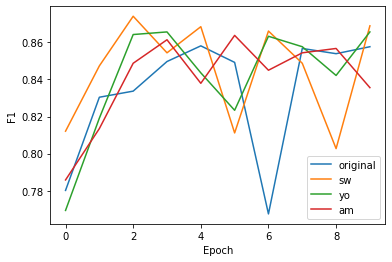

In [192]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(wo_acc)
plt.plot(swwo_acc)
plt.plot(yowo_acc)
plt.plot(amwo_acc)
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(["original", "sw","yo","am"], loc ="lower right")

plt.show()

In [183]:
mean_yo=sum(yowo_acc)/10
mean_yo

0.8414279004227337

In [184]:
mean_og=sum(wo_acc)/10
mean_og

0.8337247534053546

In [185]:
mean_sw=sum(swwo_acc)/10
mean_sw

0.8454203851573509

In [189]:
mean_am=sum(amwo_acc)/10
mean_am

0.8403006106153125

In [210]:
import pandas as pd
df=pd.DataFrame(
    {
        "Original":wo_acc,
        "Swahili":swwo_acc,
        "Amharic":amwo_acc,
        "Yoruba":yowo_acc,   
    }
)
df.to_csv('F1.csv',index=True)

In [212]:
df2=pd.DataFrame({"Average F1":[mean_og,mean_sw,mean_am,mean_yo],})
df2.index = ['Original', 'Swahili', 'Amharic', 'Yoruba']
df2.to_csv('Mean.csv',index=True)